# A gyógyászati segédeszközök társadalombiztosítási kérelmei és az infláció közötti összefüggések vizsgálata

# Könyvtárak importálása

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import json
import openai
from io import StringIO
from getpass import getpass
import os
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
os.environ['openai_api_key'] = getpass('OpenAI API kulcs: ')

OpenAI API kulcs:  ········


# Inflációs ráta (webscraping)

In [3]:
# soup
url = 'https://www.ksh.hu/stadat_files/ara/hu/ara0002.html'
response = requests.get(url)
html = response.text
soup = BeautifulSoup(html, 'lxml')

# táblázat keresése
table = soup.find('table')

# fejléc keresése
head = soup.find('thead')
header = [h.get_text(strip = True, separator=' ') for h in head.find_all('th')]

# sorok keresése
rows = []

for r in table.find_all('tr')[1:]:
  cells = [d.get_text(strip = True) for d in r.find_all(['th','td'])]
  if cells:
    rows.append(cells)

# adatok df-be töltése
df_infl = pd.DataFrame(rows, columns=header)
df_infl = df_infl[['Év', 'Összesen']]
df_infl.columns = ['Év', 'Infláció']
df_infl['Év'] = df_infl['Év'].astype(int)
df_infl['Infláció'] = df_infl['Infláció'].str.replace(',', '.')
df_infl['Infláció'] = pd.to_numeric(df_infl['Infláció'], errors='coerce')


# GYSE kérelmek importálása és adatok előkészítése

In [4]:
# GYSE kérelmek az egyes években
k2013 = 'https://www.neak.gov.hu/pfile/file?path=/letoltheto/ATFO_dok/GYSE/kerelmek/2013/KERELMEK2013-1220&inline=true'
k2014 = 'https://www.neak.gov.hu/pfile/file?path=/letoltheto/ATFO_dok/GYSE/kerelmek/2014/kerelmek2015-0107&inline=true'
k2015 = 'https://www.neak.gov.hu/pfile/file?path=/letoltheto/ATFO_dok/GYSE/kerelmek/2015/kerelmek2015-201601&inline=true'
k2016 = 'https://www.neak.gov.hu/pfile/file?path=/letoltheto/ATFO_dok/GYSE/kerelmek/2016/kerelmek2016-1230&inline=true'
k2017 = 'https://www.neak.gov.hu/pfile/file?path=/letoltheto/ATFO_dok/GYSE/kerelmek/2017/kerelmek2017-20180125&inline=true'
k2018 = 'https://www.neak.gov.hu/pfile/file?path=/letoltheto/ATFO_dok/GYSE/kerelmek/2018/kerelmek2018-20190108&inline=true'
k2019 = 'https://www.neak.gov.hu/pfile/file?path=/letoltheto/ATFO_dok/GYSE/kerelmek/Kerelem_2019/kerelmek2019-20200116&inline=true'
k2020 = 'https://www.neak.gov.hu/pfile/file?path=/letoltheto/ATFO_dok/GYSE/kerelmek/Kerelem_2020/kerelmek2020-20220223&inline=true'
k2021 = 'https://www.neak.gov.hu/pfile/file?path=/letoltheto/ATFO_dok/GYSE/kerelmek/Kerelem_2021/kerelmek2021-20220223&inline=true'
k2022 = 'https://www.neak.gov.hu/pfile/file?path=/letoltheto/ATFO_dok/GYSE/kerelmek/Kerelem_2022/kerelmek2022-20230208&inline=true'
k2023 = 'https://www.neak.gov.hu/pfile/file?path=/letoltheto/ATFO_dok/GYSE/kerelmek/Kerelem_2023/kerelmek2023-20240115&inline=true'
k2024 = 'https://www.neak.gov.hu/pfile/file?path=/letoltheto/ATFO_dok/GYSE/kerelmek/2024/kerelmek2024_250113&inline=true'
k2025 = 'https://www.neak.gov.hu/pfile/file?path=/letoltheto/ATFO_dok/GYSE/kerelmek/2025/kerelmek2025_0724&inline=true'

In [5]:
# importálás az inputok eltérő struktúrája mellett

# plusz sor, nincs ISO-oszlop
df_2013 = pd.read_excel(k2013, skiprows=1)
df_2013['ISO-kód'] = 'NaN'
df_2014 = pd.read_excel(k2014, skiprows=1)
df_2014['ISO-kód'] = 'NaN'

# nincs ISO-kód
df_2015 = pd.read_excel(k2015, skiprows=0)
df_2015['ISO-kód'] = 'NaN'
df_2016 = pd.read_excel(k2016, skiprows=0)
df_2016['ISO-kód'] = 'NaN'
df_2017 = pd.read_excel(k2017, skiprows=0)
df_2017['ISO-kód'] = 'NaN'

# ISO-kód adott
df_2018 = pd.read_excel(k2018, skiprows=0)
df_2019 = pd.read_excel(k2019, skiprows=0)
df_2020 = pd.read_excel(k2020, skiprows=0)
df_2021 = pd.read_excel(k2021, skiprows=0)
df_2022 = pd.read_excel(k2022, skiprows=0)
df_2023 = pd.read_excel(k2023, skiprows=0)
df_2024 = pd.read_excel(k2024, skiprows=0)
df_2025 = pd.read_excel(k2025, skiprows=0)

# azonos struktúrába rendezés
df_2013 = df_2013[df_2025.columns]
df_2014 = df_2014[df_2025.columns]
df_2015 = df_2015[df_2025.columns]
df_2016 = df_2016[df_2025.columns]
df_2017 = df_2017[df_2025.columns]

In [6]:
# évenkénti adatok összekapcsolása egy táblába
df_all = pd.concat([df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, 
                    df_2019, df_2020, df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)

# Adatok tisztítása

In [7]:
df_all = df_all[['ISO-kód', 'Ügy tárgya', 'Kérelem típusa', 'Kérelmező neve', 'Eljárás megindításának napja']]
df_all.columns = ['ISO', 'Eszköz', 'Kérelem', 'Kérelmező', 'Év']
df_all['Év'] = pd.to_datetime(df_all['Év'], errors='coerce')
df_all['Év'] = df_all['Év'].dt.year
df_all['Év'] = df_all['Év'].fillna(0).astype(int)

# vizsgált kérelemtípusok kiszűrése: új eszköz befogadása, áremelési kérelem, befogadott eszköz törlése
df_subm = df_all[(df_all['Kérelem'] == 'új termék (aa)') | (df_all['Kérelem'] == 'áremelés (bf)') | (df_all['Kérelem'] == 'törlés (bg)') ]

In [8]:
# hiányzó ISO-kódok
df_subm[['ISO']][df_subm.ISO == 'NaN'].count()

ISO    1037
dtype: int64

In [9]:
# ismert ISO-kódok esetén csoportosítás
iso2 = {
    '02': 'kötszer', 
    '04': 'személyes gyógykezelés', 
    '06': 'ortézis/protézis/ortopéd cipő', 
    '09': 'ruha/védelem/higiéné',
    '12': 'járás/moped/kerekesszék/tájékozódás', 
    '15': 'evés/ivás', 
    '18': 'bútor',
    '21': 'látás/hallás/jeladás' }

df_subm = df_subm.copy()
df_subm.loc[:, 'Csoport'] = df_subm['ISO'].str[:2].map(iso2)

In [10]:
# ISO csoportok meghatározása a Nemzeti Egészségbiztosítási Alapkezelő Online SEgédeszköz JegyzéK főbb kulcsszavai alapján

df_ISONaN = df_subm[(df_subm['Csoport'].isna())]

df_ISONaN.loc[df_ISONaN['Eszköz'].str.contains('kötszer|kötés|habszivacs|hydrokolloid|hydrogél|alginát|mull|gézlap|sebpárna|ragtapasz', 
                                                regex=True, case=False), 'Csoport'] = 'kötszer'
df_ISONaN.loc[df_ISONaN['Eszköz'].str.contains('inhalátor|oxigén|párásító|CPAP|BiPAP|váladékszívó|szívókészülék|flutter|pipa|orrmaszk|sérv|Mainat|harisnyanadrág|karharisnya|térdharisnya|inzulinpumpa|holttér nélküli fecskendő|fecskendőtű|pen tű|teszt|vércukormérő|szintmérő|ingerlő|okklúzió|torna', 
                                                regex=True, case=False), 'Csoport'] = 'személyes gyógykezelés'
df_ISONaN.loc[df_ISONaN['Eszköz'].str.contains('ortézis|emlőprotézis|peroneus|térdrögzítő|fűző|boka|gerinc|medence|paróka|műfog|fogsor|korona|ortopéd cipő', 
                                                regex=True, case=False), 'Csoport'] = 'ortézis/protézis/ortopéd cipő'
df_ISONaN.loc[df_ISONaN['Eszköz'].str.contains('melltartó|csonkharisnya|wc magasító|kanül|zsák|zacskó|sztóma|inkontinencia|pelenka|ballon katéter|hidrofil katéter|vizelet|rögzítőnadrág|szobai wc', 
                                               regex=True, case=False), 'Csoport'] = 'ruha/védelem/higiéné'
df_ISONaN.loc[df_ISONaN['Eszköz'].str.contains('fémbot|fehérbot|járóbot|mankó|járókeret|kerekesszék|moped|tapogatóbot|akkumulátor', 
                                               regex=True, case=False), 'Csoport'] = 'járás/moped/kerekesszék/tájékozódás'
df_ISONaN.loc[df_ISONaN['Eszköz'].str.contains('szonda|gasztro|táplálópumpa|enterális|öblítő fecskendő', 
                                               regex=True, case=False), 'Csoport'] = 'evés/ivás'
df_ISONaN.loc[df_ISONaN['Eszköz'].str.contains('lábtámasz|háttámasz|kartámasz|antidecubitus|kapaszkodó', 
                                               regex=True, case=False), 'Csoport'] = 'bútor'
df_ISONaN.loc[df_ISONaN['Eszköz'].str.contains('sph.|focalis|lencse|műszem|szemüveg|hangprotézis|műgége|hallókészülék|szenzor|távadó|ébresztő', 
                                               regex=True, case=False), 'Csoport'] = 'látás/hallás/jeladás'

df_subm['Csoport'].update(df_ISONaN['Csoport'])

In [11]:
# hiányzó csoportok
df_ISONaN[['Eszköz']][df_ISONaN['Csoport'].isna()].count()

Eszköz    48
dtype: int64

In [12]:
df_ISONaN

,ISO,Eszköz,Kérelem,Kérelmező,Év,Csoport
34,NaN,Wellion Calla 50 db/doboz vmérő tesztcsík,új termék (aa),Premium Health Concepts Kft.,2012,személyes gyógykezelés
35,NaN,QS-610 Ortopédiai fűző Ágyék-keresztcsont orté...,új termék (aa),REHAB Zrt.,2013,ortézis/protézis/ortopéd cipő
37,NaN,ReSound Alera 910 hallókészülék,új termék (aa),Danavox-H Kft.,2013,látás/hallás/jeladás
38,NaN,ReSound Alera 930 hallókészülék,új termék (aa),Danavox-H Kft.,2013,látás/hallás/jeladás
39,NaN,Dansac Solo sztómaterápiás eszköz,törlés (bg),Hollister Kft.,2013,ruha/védelem/higiéné
...,...,...,...,...,...,...
1691,NaN,"Actreen Lite Cath Nelaton steril, síkosított, ...",új termék (aa),B. Braun Trading Kft.,2017,NaN
1692,NaN,"Actreen Lite Cath Nelaton steril, síkosított, ...",új termék (aa),B. Braun Trading Kft.,2017,NaN
1693,NaN,iD Pants Plus L (1653 ml) inkontinencia eszköz,új termék (aa),Inco-Med Kft.,2017,ruha/védelem/higiéné
1694,NaN,Dcont Monda vércukormérő készülék,új termék (aa),77 Elektronika Kft.,2017,személyes gyógykezelés


In [13]:
# ismeretlen ISO-csoportú kérelmek leszűrése
df_ISONaN = df_ISONaN[(df_ISONaN['Csoport'].isna())]
df_ISONaN = df_ISONaN.reset_index(drop=False)
df_ISONaN.columns = ['Kulcs', 'ISO', 'Eszköz', 'Kérelem', 'Kérelmező', 'Év', 'Csoport']
df_toAI = df_ISONaN[['Kulcs', 'Eszköz']]
df_toAI.count()

Kulcs     48
Eszköz    48
dtype: int64

In [14]:
df_toAI

,Kulcs,Eszköz
0,110,RT-4021 GF szoba WC
1,121,Gyógyorr antiallergiás készülék
2,122,Salus RMP 5m x 12 cm kompressziós pólya
3,216,LoFric Tiemann hidrofil felületű műanyag lecsa...
4,221,BE 1370 Bellman digitális ébretőóra
5,265,POWERbreathe Medic maszk maszk
6,332,Injekt 2 ml (2 részes) fecskendő
7,333,Injekt 5 ml (2 részes) fecskendő
8,359,RESMED Swift FX orrpárna maszk Maszk
9,360,RESMED Swift FX for Her orrpárna maszk (női) M...


# Név alapján történő kategorizálás AI segítségével

In [15]:
# feladatmeghatározás az AI-nak
prompt = ("Elemezd a df_toAI df-t."
          "Kulcs-értékeket és gyógyászati segédeszközök neveit tartalmazza"  
          "Értelmezd és nevük alapján sorold az alábbi csoportok egyikébe. Pontosan ezen kategóriákat használd:"
          "kötszer, személyes gyógykezelés, ortézis/protézis/ortopéd cipő, ruha/védelem/higiéné, "
          "járás/moped/kerekesszék/tájékozódás, evés/ivás, bútor/lakás, látás/hallás/jeladás "
          "Az eredeti oszlopok értékeit tartsd meg, ne változtass a kulcs-oszlop értékein se!"
          "Csak a csoportokkal kiegészített df-t küldd vissza .csv formátumban pontosvesszővel elválasztva, mást ne!"
          "A df fejlécei: Kulcs, Eszköz, Csoport"
          "Itt az eredeti df:")

message = prompt + str(df_toAI)

In [16]:
# feladat elküldése az AI-nak

openai_api_key = os.environ['openai_api_key']

url = 'https://api.openai.com/v1/chat/completions'

headers = {'Content-Type': 'application/json', 'Authorization': f'Bearer {openai_api_key}'}

data = {'model': 'gpt-4o-mini', 'messages': [{'role': 'user', 'content': message}], 'temperature': 0.7}

response = requests.post(url, headers=headers, data=json.dumps(data))

In [17]:
# AI válaszából a szükséges adatok tisztítása és kinyerése
raw_text = response.json()['choices'][0]['message']['content']

cleaned_text = '\n'.join(raw_text.strip().splitlines()[1:-1])

df_back = pd.read_csv(StringIO(cleaned_text), sep=';')
df_back.head(10)

,Kulcs,Eszköz,Csoport
0,0,RT-4021 GF szoba WC,bútor/lakás
1,1,Gyógyorr antiallergiás készülék,személyes gyógykezelés
2,2,Salus RMP 5m x 12 cm kompressziós pólya,kötszer
3,3,LoFric Tiemann hidrofil felületű műanyag lecsa...,személyes gyógykezelés
4,4,BE 1370 Bellman digitális ébretőóra,járás/moped/kerekesszék/tájékozódás
5,5,POWERbreathe Medic maszk maszk,személyes gyógykezelés
6,6,Injekt 2 ml (2 részes) fecskendő,személyes gyógykezelés
7,7,Injekt 5 ml (2 részes) fecskendő,személyes gyógykezelés
8,8,RESMED Swift FX orrpárna maszk Maszk,személyes gyógykezelés
9,9,RESMED Swift FX for Her orrpárna maszk (női) M...,személyes gyógykezelés


In [18]:
# AI csoportosítás visszatöltése az eredeti táblába
df_ISONaN['Csoport'].update(df_back['Csoport'])
update_df = df_ISONaN[['Kulcs', 'Csoport']]
update_df = update_df.set_index('Kulcs')
df_subm['Csoport'].update(update_df['Csoport'])

In [19]:
# AI csoportosítás visszatöltése az eredeti táblába
df_ISONaN['Csoport'].update(df_back['Csoport'])
df_csoport = df_ISONaN[['Kulcs', 'Csoport']]
df_csoport = df_csoport.set_index('Kulcs')
df_subm['Csoport'].update(df_csoport['Csoport'])
df_subm.head()

,ISO,Eszköz,Kérelem,Kérelmező,Év,Csoport
34,NaN,Wellion Calla 50 db/doboz vmérő tesztcsík,új termék (aa),Premium Health Concepts Kft.,2012,személyes gyógykezelés
35,NaN,QS-610 Ortopédiai fűző Ágyék-keresztcsont orté...,új termék (aa),REHAB Zrt.,2013,ortézis/protézis/ortopéd cipő
37,NaN,ReSound Alera 910 hallókészülék,új termék (aa),Danavox-H Kft.,2013,látás/hallás/jeladás
38,NaN,ReSound Alera 930 hallókészülék,új termék (aa),Danavox-H Kft.,2013,látás/hallás/jeladás
39,NaN,Dansac Solo sztómaterápiás eszköz,törlés (bg),Hollister Kft.,2013,ruha/védelem/higiéné


In [20]:
# ismeretlen csoportú kérelmek ellenőrzése
df_subm[df_subm['Csoport'].isna()]

,ISO,Eszköz,Kérelem,Kérelmező,Év,Csoport


# Kérelmek és infláció alakulása

#### Összes kérelem

In [21]:
# kérelemszám és inflációs adatok előkészítése a diagramhoz
df_counts = df_subm.groupby(['Év', 'Kérelem']).size().reset_index(name='Darab')
df_pivot = df_counts.pivot(index='Év', columns='Kérelem', values='Darab').fillna(0).reset_index()
df_subm = df_subm.merge(df_infl, how='left', on='Év')
df_infl = df_subm.groupby('Év')['Infláció'].mean().reset_index()

# kérelmek és infláció ábrázolása
fig = px.line(df_pivot, x='Év', 
              y=df_pivot.columns[1:], 
              markers=False,
              title='Kérelmek alakulása és infláció')

fig.add_trace(go.Scatter(x=df_infl['Év'], 
                         y=df_infl['Infláció'], 
                         mode='lines', 
                         name='Infláció (%)',
                         line=dict(color='black', dash='dash')
                        )
             )

# másodlagos y-tengely definiálása
fig.update_layout(
    width=700, height=500,  
    plot_bgcolor='white',   
    paper_bgcolor='white',
    xaxis=dict(title='Év', linecolor='black'),
    yaxis=dict(title='Kérelmek száma', linecolor='black'),
    yaxis2=dict(title='Infláció (%)',  linecolor='black', overlaying='y', side='right'),
    legend=dict(title='Kérelem típusa', orientation='h', y=-0.2)
)

# második y-tengely inflációhoz rendelése
fig.data[-1].update(yaxis='y2')

fig.show()

In [22]:
# összes kérelem típusonként a teljes időszakban 
df_subm[['Kérelem', 'Eszköz']].groupby('Kérelem').count()

,Eszköz
Kérelem,
törlés (bg),1501
áremelés (bf),306
új termék (aa),1294


In [23]:
# korreláció számításához a kérelmek és az infláció előkészítése
df_corr = df_subm[['Év', 'Kérelem']].groupby(['Év']).count()
df_corr = df_corr.merge(df_subm.groupby(['Év', 'Kérelem']).size().unstack(fill_value=0), on = 'Év')
df_corr = df_corr.merge(df_infl, how='left', on='Év')
df_corr.head()

,Év,Kérelem,törlés (bg),áremelés (bf),új termék (aa),Infláció
0,2012,2,0,0,2,105.7
1,2013,141,41,2,98,101.7
2,2014,285,127,31,127,99.8
3,2015,241,155,3,83,99.9
4,2016,204,75,0,129,100.4


In [24]:
# korrelációs mátrix
corr_matrix = df_corr[['Kérelem', 'törlés (bg)', 'áremelés (bf)', 'új termék (aa)', 'Infláció']].corr()

# korrelációs hőtérkép
fig = px.imshow(corr_matrix, text_auto=True, aspect='auto',
                labels=dict(color='Korreláció'),
                x=corr_matrix.columns,
                y=corr_matrix.columns,
                width = 650, height = 500,
                title='Korreláció a kérelem típusa és az infláció között',
                color_continuous_scale=[(0.00, 'brown'), (0.50, 'white'), (1.00, 'purple')])

fig.update_coloraxes(cmin=-1, cmax=1)

fig.show()

#### Áremelési kérelmek

In [25]:
# korreláció számításához az áremelési kérelmek és az infláció előkészítése
df_corr_bf_cs = (df_subm.loc[df_subm['Kérelem'] == 'áremelés (bf)'].groupby(['Év', 'Csoport']).size().unstack(fill_value=0))
df_corr_bf_cs = df_corr_bf_cs.merge(df_infl, how='inner', on='Év')

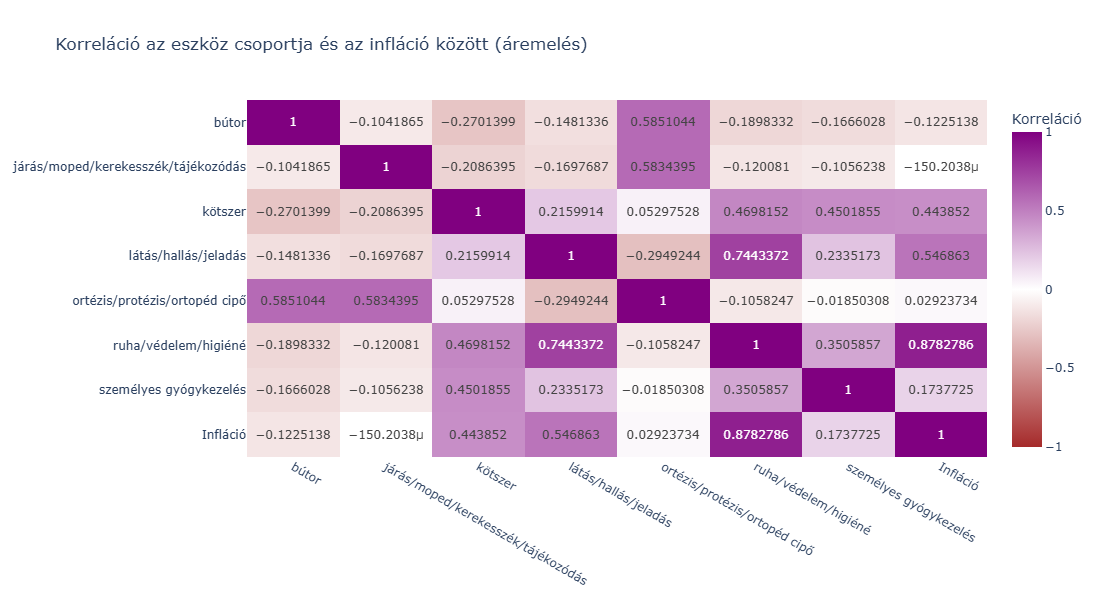

In [26]:
# korrelációs mátrix
corr_bf_cs_matrix = df_corr_bf_cs[['bútor', 'járás/moped/kerekesszék/tájékozódás', 
                               'kötszer', 'látás/hallás/jeladás', 
                               'ortézis/protézis/ortopéd cipő', 'ruha/védelem/higiéné', 
                               'személyes gyógykezelés', 'Infláció']].corr()

# korrelációs hőtérkép
fig = px.imshow(corr_bf_cs_matrix, text_auto=True, aspect='auto',
                labels=dict(color='Korreláció'),
                x=corr_bf_cs_matrix.columns,
                y=corr_bf_cs_matrix.columns,
                width = 1000, height = 600,
                title='Korreláció az eszköz csoportja és az infláció között (áremelés)',
                color_continuous_scale=[(0.00, 'brown'), (0.50, 'white'), (1.00, 'purple')])

fig.update_coloraxes(cmin=-1, cmax=1)

fig.show()

#### Törlésre irányuló kérelmek

In [27]:
# korreláció számításához a törlésre irányuló kérelmek és az infláció előkészítése
df_corr_bg_cs = (df_subm.loc[df_subm['Kérelem'] == 'törlés (bg)'].groupby(['Év', 'Csoport']).size().unstack(fill_value=0))
df_corr_bg_cs = df_corr_bg_cs.merge(df_infl, how='inner', on='Év')

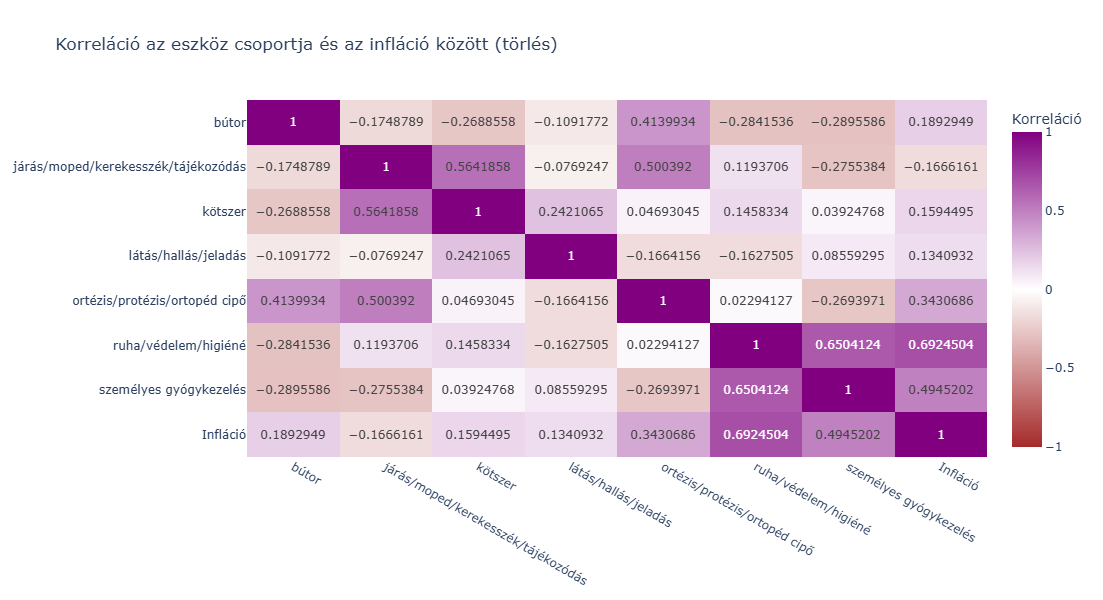

In [28]:
# korrelációs mátrix
corr_bg_cs_matrix = df_corr_bg_cs[['bútor', 'járás/moped/kerekesszék/tájékozódás', 
                               'kötszer', 'látás/hallás/jeladás', 
                               'ortézis/protézis/ortopéd cipő', 'ruha/védelem/higiéné', 
                               'személyes gyógykezelés', 'Infláció']].corr()

# korrelációs hőtérkép
fig = px.imshow(corr_bg_cs_matrix, text_auto=True, aspect='auto',
                labels=dict(color='Korreláció'),
                x=corr_bg_cs_matrix.columns,
                y=corr_bg_cs_matrix.columns,
                width = 1000, height = 600,
                title='Korreláció az eszköz csoportja és az infláció között (törlés)',
                color_continuous_scale=[(0.00, 'brown'), (0.50, 'white'), (1.00, 'purple')])

fig.update_coloraxes(cmin=-1, cmax=1)

fig.show()

#### Áremelési kérelmet követő törlés (feltételezett elutasítás esetén)

In [29]:
# áremelési kérelmet követő törlés 1 éven belül
df_bf_bg = df_subm[['Eszköz', 'Év', 'Csoport']][df_subm['Kérelem'] == 'áremelés (bf)'].merge(df_subm[['Eszköz', 'Év']][df_subm['Kérelem'] == 'törlés (bg)'], 
                                                                                             how = 'inner', on ='Eszköz', suffixes=('_bf', '_bg'))
df_bf_bg[['Eszköz', 'Csoport']][((df_bf_bg['Év_bg'] - df_bf_bg['Év_bf']))<=1]

,Eszköz,Csoport
0,Mesorb 23 x 30 cm (Hasznos méret: 20 x 30 cm) ...,kötszer
1,Tena Flex Plus S (1190 ml) nadrágpelenka,ruha/védelem/higiéné
2,Tena Flex Plus XL (1990 ml) nadrágpelenka,ruha/védelem/higiéné
6,Anita Compression melltartó,ruha/védelem/higiéné
7,Seni Soft Super egyszerhasználatos antidecubit...,bútor
8,Seni Soft Super egyszerhasználatos antidecubit...,bútor
11,"Grassolind kenőcstüll 7,5 x 10 cm kötszer",kötszer
12,"Grassolind kenőcstüll 7,5 x 10 cm kötszer",kötszer
14,"Nelaton Norta 100% szilikon ballon katéter, 10...",ruha/védelem/higiéné


#### Árérzékeny kérelmezők vizsgálata

In [30]:
# áremelésre irányuló kérelmek alakulása kérelmező szerint és az infláció alakulása közötti összefüggés
df_ceg_bf = df_subm[['Kérelmező', 'Év', 'Csoport']][df_subm['Kérelem'] == 'áremelés (bf)'].groupby(['Kérelmező', 'Év']).count().reset_index()
df_ceg_bf = df_ceg_bf.merge(df_infl, on = 'Év', how = 'left')

# kérelmezők kiszűrése a korreláció számításához, akik legalább 3 évben nyújtottak be áremelési kérelmet
df_ceg_bf_filtered = df_ceg_bf[df_ceg_bf.groupby('Kérelmező')['Csoport'].transform('size') >= 3]

# korreláció számítása
corr_ceg_bf = df_ceg_bf_filtered.groupby('Kérelmező')[['Csoport', 'Infláció']].corr().loc[pd.IndexSlice[:, 'Csoport'], 'Infláció']
df_ceg_bf = corr_ceg_bf.reset_index()
df_ceg_bf.columns = ['Kérelmező', 'Kérelem', 'Korreláció']

# erős pozitív (árérzékeny) kérelmezők szűrése
df_ceg_bf = df_ceg_bf[['Kérelmező', 'Korreláció']][df_ceg_bf['Korreláció'] >= 0.7]
df_ceg_bf

,Kérelmező,Korreláció
4,TZMO Hungary Kft.,0.709847


In [31]:
# árérzékeny kérelmezők kérelmei az eszköz csoportja szerint
df_bf = df_subm[['Kérelmező', 'Kérelem', 'Csoport']][df_subm['Kérelem'] == 'áremelés (bf)'].merge(df_ceg_bf, on='Kérelmező', how = 'inner')
df_bf.groupby(['Kérelmező', 'Csoport']).count()['Kérelem'].reset_index()

,Kérelmező,Csoport,Kérelem
0,TZMO Hungary Kft.,kötszer,2
1,TZMO Hungary Kft.,ruha/védelem/higiéné,56


In [32]:
# törlésre irányuló kérelmek alakulása kérelmező szerint és az infláció alakulása közötti összefüggés
df_ceg_bg = df_subm[['Kérelmező', 'Év', 'Kérelem']][df_subm['Kérelem'] == 'törlés (bg)'].groupby(['Kérelmező', 'Év']).count().reset_index()
df_ceg_bg = df_ceg_bg.merge(df_infl, on = 'Év', how = 'left')

# kérelmezők kiszűrése a korreláció számításához, akik legalább 3 évben nyújtottak be törlési kérelmet
df_ceg_bg_filtered = df_ceg_bg[df_ceg_bg.groupby('Kérelmező')['Kérelem'].transform('size') >= 3]

# korreláció számítása
corr_ceg_bg = df_ceg_bg_filtered.groupby('Kérelmező')[['Kérelem', 'Infláció']].corr().loc[pd.IndexSlice[:, 'Kérelem'], 'Infláció']
df_ceg_bg = corr_ceg_bg.reset_index()
df_ceg_bg.columns = ['Kérelmező', 'Kérelem', 'Korreláció']

# erős pozitív kapcsolatot mutató kérelmezők szűrése
df_ceg_bg = df_ceg_bg[['Kérelmező', 'Korreláció']][df_ceg_bg['Korreláció'] >= 0.7]
df_ceg_bg

,Kérelmező,Korreláció
4,Csuti Gyógyászati Segédeszköz Kft.,0.710440
5,Di-Care Zrt.,1.000000
10,Lohmann & Rauscher Hungary Kft.,1.000000
14,Medtronic Hungária Kft.,1.000000
17,Otto Bock Hungária Kft.,1.000000
20,Replant 4 Care Kft.,0.964996
21,SALUS Orthopedtechnika Kft.,1.000000


In [33]:
# a törlés és az infláció között pozitív erős kapcsolatot mutató kérelmezők kérelmei az eszköz csoportja szerint
df_bg = df_subm[['Kérelmező', 'Kérelem', 'Csoport']][df_subm['Kérelem'] == 'törlés (bg)'].merge(df_ceg_bg, on='Kérelmező', how = 'inner')
df_bg.groupby(['Kérelmező', 'Csoport']).count()['Kérelem'].reset_index()

,Kérelmező,Csoport,Kérelem
0,Csuti Gyógyászati Segédeszköz Kft.,ruha/védelem/higiéné,13
1,Di-Care Zrt.,látás/hallás/jeladás,3
2,Di-Care Zrt.,személyes gyógykezelés,1
3,Lohmann & Rauscher Hungary Kft.,kötszer,9
4,Lohmann & Rauscher Hungary Kft.,személyes gyógykezelés,15
5,Medtronic Hungária Kft.,látás/hallás/jeladás,3
6,Medtronic Hungária Kft.,személyes gyógykezelés,2
7,Otto Bock Hungária Kft.,járás/moped/kerekesszék/tájékozódás,6
8,Otto Bock Hungária Kft.,ortézis/protézis/ortopéd cipő,2
9,Replant 4 Care Kft.,evés/ivás,2
